In [2]:
# Import libraries
import sys
import os
# Add src to path
sys.path.append(os.path.abspath('src'))
from pathlib import Path
from matplotlib import pyplot as plt
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from functools import reduce
from typing import *
import matplotlib
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from collections import defaultdict
from eval_plots import plot_training_curves, make_plasma_vae_plots
from torch.utils.data import TensorDataset, DataLoader, random_split
sns.set_style("whitegrid")

# Convolutional Variational Autoencoder
------------
*A summation of what the next couple of cells, in order, do*
- The data is imported (here we use the 128x128 nHESEL images of which $N=501$) and an example is plotted, ensuring what kind of data we are dealing with
- Partitioning of data (validation, test)
- Defining **ReparameterizedDiagonalGaussian**
- Defining **ConvolutionalVariationalAutoencoder**
- Defining **VariationalInference**
- After the definitions, a small example (a single image) is given as an input to the model as a dummy to see if the network behaves as expected 

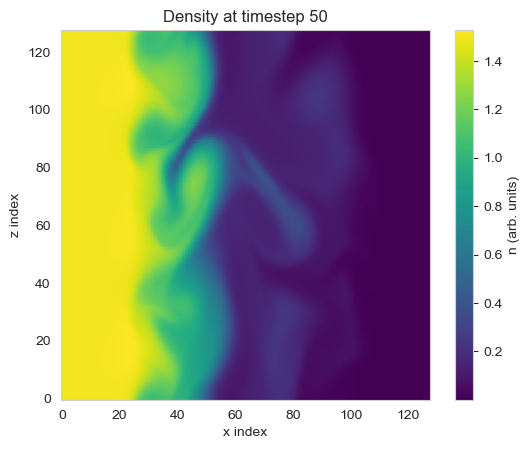

In [4]:
# Load data
DATA_LOCATION = Path(
	r"data_numpy/density_large128.npy"
)

# Plot a single timestep
def plot_timestep(density,idx):
	plt.figure()
	plt.imshow(density[idx,:,:].T, origin='lower', cmap='viridis')
	plt.colorbar(label="n (arb. units)")
	plt.xlabel("x index")
	plt.ylabel("z index")
	plt.title("Density at timestep 50")
	plt.grid(False)
	plt.show()

data = np.load(DATA_LOCATION)
plot_timestep(data, idx=10)

# Normalize data
max_val = np.max(data)
density_data = data/max_val

In [5]:
# Convert to tensor and add channel dimension
data_tensor = torch.tensor(density_data, dtype=torch.float32)
data_tensor = data_tensor.unsqueeze(1) 

print(data_tensor.shape)

# Split into train and test sets
total_count = len(data_tensor)
train_size = int(0.8 * total_count)
test_size = total_count - train_size

train_dataset, test_dataset = random_split(data_tensor, [train_size, test_size])

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([501, 1, 128, 128])


In [6]:
# Gaussian distribution with reparameterization trick
class ReparameterizedDiagonalGaussian(Distribution):
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        epsilon = self.sample_epsilon()
        return self.mu + self.sigma * epsilon
            
    def log_prob(self, z:Tensor) -> Tensor:
        return -0.5 * (math.log(2 * math.pi) + 2 * torch.log(self.sigma) + ((z - self.mu) ** 2) / (self.sigma ** 2))

### Convolutional-VAE properties
-------
For images of size 128x128, the following augmentations are performed for each layer:

##### (Encoder)

| Step | Layer                           | Output Shape            |
| ---- | ------------------------------- | ----------------------- |
| 1    | Input                           | **1 × 128 × 128**       |
| 2    | Conv2d(1 → 32), stride=2        | **32 × 64 × 64**        |
| 3    | Conv2d(32 → 64), stride=2       | **64 × 32 × 32**        |
| 4    | Conv2d(64 → 128), stride=2      | **128 × 16 × 16**       |
| 5    | Conv2d(128 → 256), stride=2     | **256 × 8 × 8**         |
| 6    | Flatten                         | **256×8×8 = 16384**     |
| 7    | Linear → produces mean + logvar | **latent_features × 2** |

##### (Decoder)

| Step | Layer                                | Output Shape                          |
| ---- | ------------------------------------ | ------------------------------------- |
| 1    | Linear → reshape                     | **256 × 8 × 8**                       |
| 2    | ConvTranspose2d(256 → 128), stride=2 | **128 × 16 × 16**                     |
| 3    | ConvTranspose2d(128 → 64), stride=2  | **64 × 32 × 32**                      |
| 4    | ConvTranspose2d(64 → 32), stride=2   | **32 × 64 × 64**                      |
| 5    | ConvTranspose2d(32 → 1), stride=2    | **1 × 128 × 128**                     |
| 6    | Sigmoid                              | **1 × 128 × 128** (normalized output) |


In [7]:
# VAE model with convolutional encoder and decoder
class ConvolutionalVariationalAutoencoder(nn.Module):
    def __init__(self, input_shape:torch.Size, latent_features: int, in_channels: int = 1) -> None:
        super().__init__()
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.in_channels = in_channels
        
        # Encoder
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, latent_features * 2) 
        )

        # Decoder
        self.conv_decoder = nn.Sequential(
            nn.Linear(latent_features, 256 * 8 * 8),
            nn.Unflatten(dim=1, unflattened_size=(256, 8, 8)),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        self.register_buffer("prior_params", torch.zeros(1, 2 * latent_features))
        self.log_scale = nn.Parameter(torch.tensor([0.0]))

        
    def posterior(self, x:Tensor) -> Distribution:
        h_x = self.conv_encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        log_sigma = torch.clamp(log_sigma,min=-10, max=10)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    def prior(self, batch_size:int=1)-> Distribution:
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        mu = self.conv_decoder(z)
        scale = torch.exp(self.log_scale)
        return torch.distributions.Normal(mu, scale)
        
    def forward(self, x) -> Dict[str, Any]:
        qz = self.posterior(x)
        pz = self.prior(batch_size=x.size(0))
        z = qz.rsample()
        px = self.observation_model(z)
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
        
    def sample_from_prior(self, batch_size: int = 16) -> Dict[str, Any]:
        pz = self.prior(batch_size=batch_size)
        z = pz.rsample()
        px = self.observation_model(z)
        return {"px": px, "pz": pz, "z": z}

In [8]:
def reduce(x:Tensor) -> Tensor:
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        outputs = model(x)
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # Calculate ELBO and KL divergence
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        loss = -beta_elbo.mean()
        
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [9]:
from collections import defaultdict

# Initialize model
latent_features = 16
cvae = ConvolutionalVariationalAutoencoder(data_tensor[0].shape, latent_features)

# Setup variational inference
beta = 0.75
vi = VariationalInference(beta=beta)

# Optimizer
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

# Track training metrics
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

### Checking if the model can process the data

We pass a single image through the Convolutional-VAE, checking that it can produce an image of same size. Although it does this, it produces an awful image of random colored points, which is expected since the model has not yet been trained!

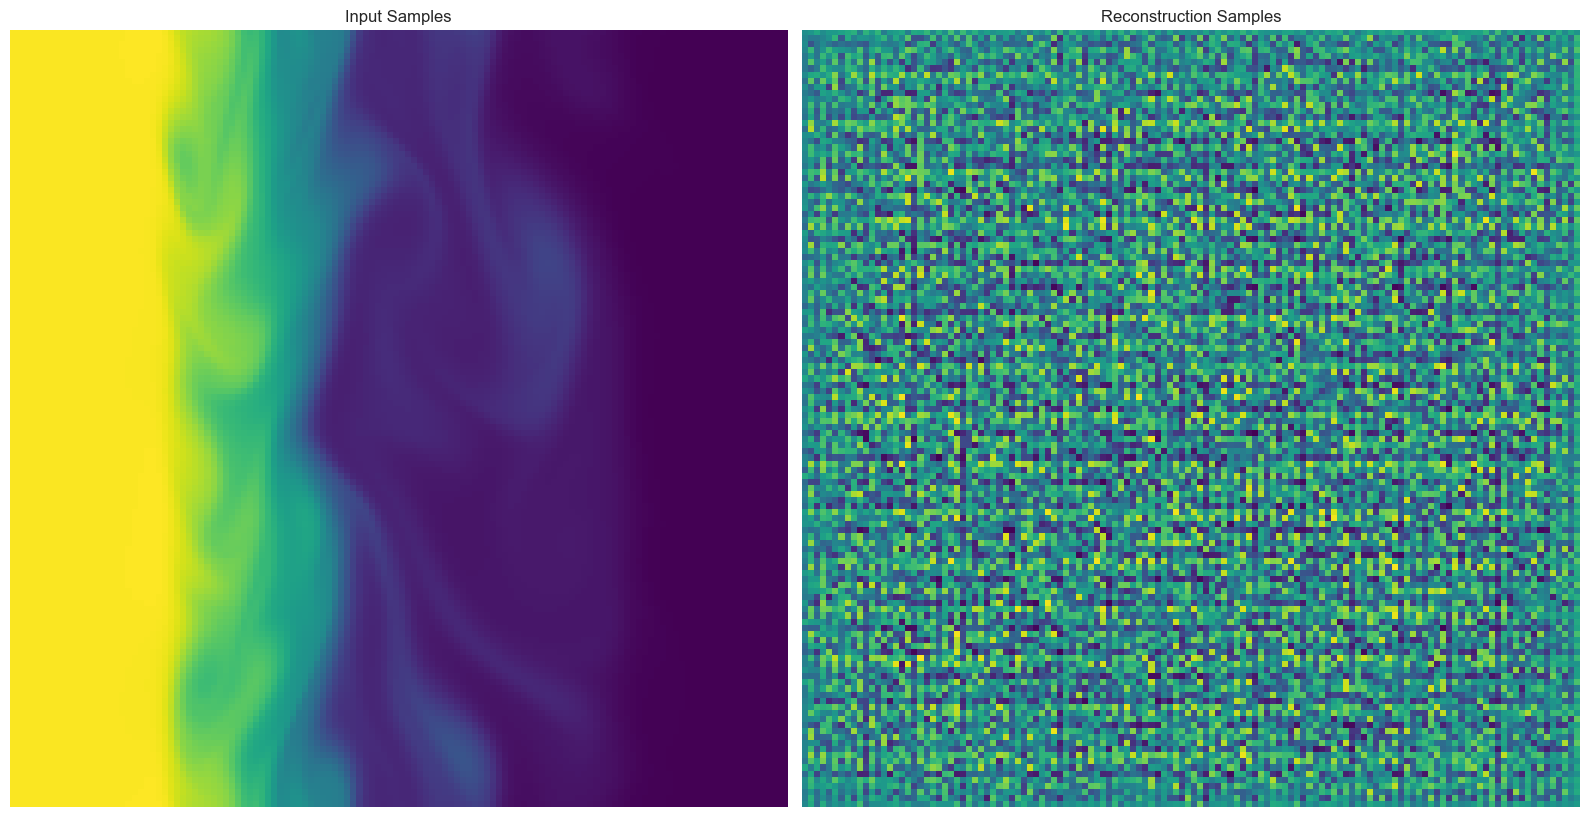

In [ ]:
from torchvision.utils import make_grid

dummy_tensor = data_tensor[0:1,:,:,:]

# Extract output
outputs = cvae(dummy_tensor)
px = outputs['px']

# Plot input vs reconstruction
fig, axes = plt.subplots(1, 2, figsize=(16,14))

axes[0].set_title("Input Samples")
x_input = dummy_tensor 

img = x_input[0, 0].cpu().numpy().T[::-1, :] 
axes[0].imshow(img, cmap='viridis')
axes[0].axis("off")

axes[1].set_title("Reconstruction")
img_hat = px.mean[0, 0].cpu().detach().numpy().T[::-1, :]
axes[1].imshow(img_hat, cmap='viridis')
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [12]:
from collections import defaultdict

# Re-initialize model with 26 latent features
latent_features = 26
cvae = ConvolutionalVariationalAutoencoder(data_tensor[0].shape, latent_features)

# Setup inference
beta = 0.75 
vi = VariationalInference(beta=beta)

optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

training_data = defaultdict(list)
validation_data = defaultdict(list)

### Training and Validation loop

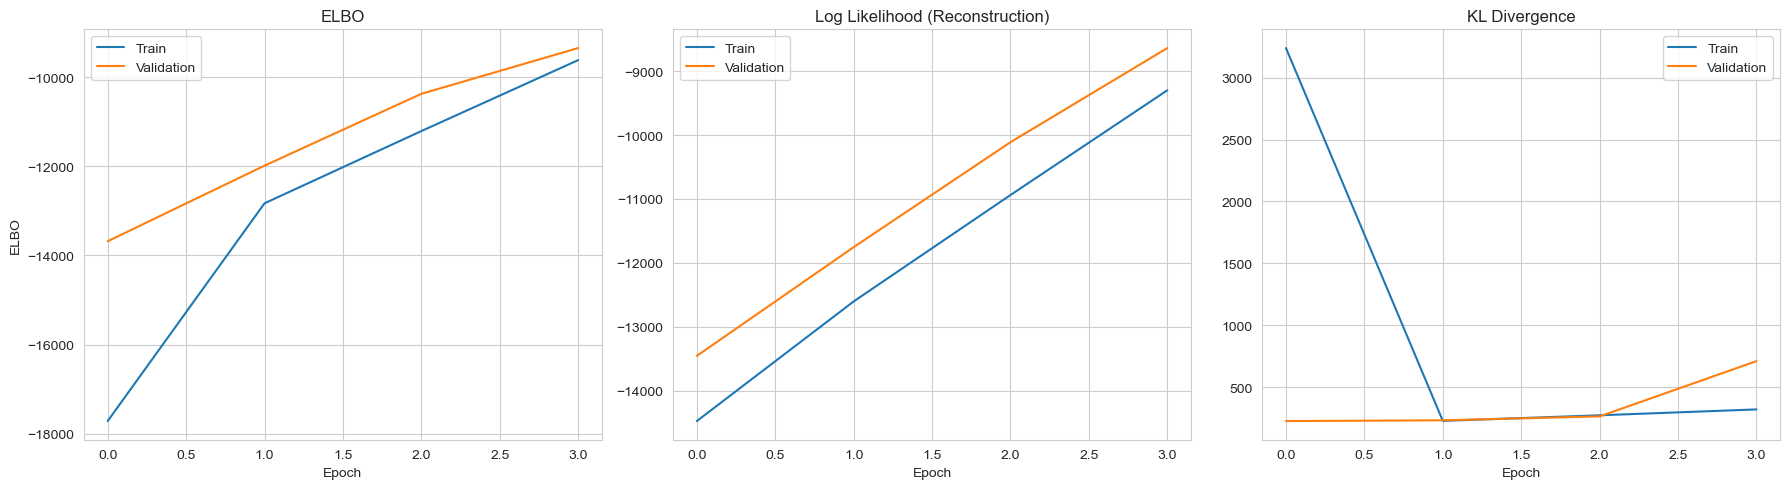

In [14]:
num_epochs = 2 # change the number of epochs here! 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

cvae = cvae.to(device)

# Training loop
epoch = 0
while epoch < num_epochs:
    epoch+= 1

    training_epoch_data = defaultdict(list)
    cvae.train()
    
    for x in train_loader:
        x = x.to(device)
        
        loss, diagnostics, outputs = vi(cvae, x)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(cvae.parameters(), 1.0)

        optimizer.step()
        
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
      

    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Validation
    with torch.no_grad():
        cvae.eval()
        
        validation_epoch_data = defaultdict(list)
        
        for x in test_loader:
            x = x.to(device)
            
            loss, diagnostics, outputs = vi(cvae, x)
            
            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]
        
        for k, v in validation_epoch_data.items():
            validation_data[k] += [np.mean(v)]
    
    # Plot progress
    if epoch % 1 == 0:
        clear_output(wait=True)
        train_vis = {k: v for k, v in training_data.items()}
        val_vis = {k: v for k, v in validation_data.items()}
        
        plot_training_curves(train_vis, val_vis)

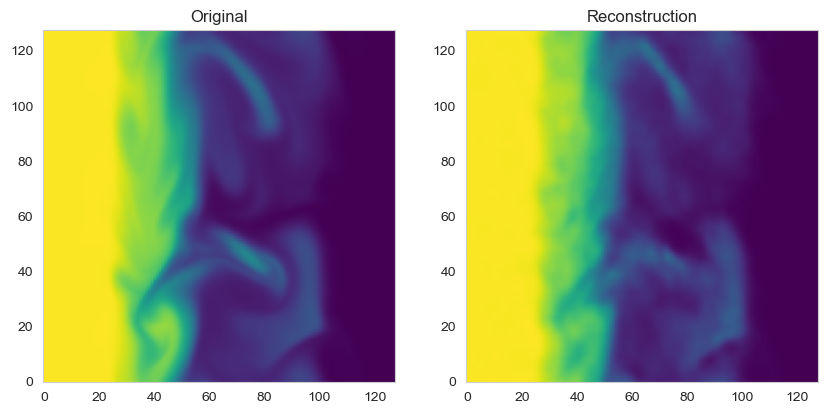

In [15]:
# Load pre-trained VAE
sys.path.append(os.path.abspath('models'))
from Models.VAE_128 import ConvolutionalVariationalAutoencoder, VariationalInference

experiments_folder = os.path.abspath('experiments')
trained_network_path = os.path.join(experiments_folder, "model_26_e3_0.75_200epochs/model_weights_26_e3_0.75_200epochs.pth")

latent_features = 26
input_size = 128
vae = ConvolutionalVariationalAutoencoder(input_size, latent_features)
vae.load_state_dict(torch.load(trained_network_path, map_location=torch.device('cpu')))
vae.eval()

# Load test images
data_folder = os.path.abspath('data_numpy')
images_path = os.path.join(data_folder, 'density_large128.npy')
images = np.load(images_path)
x_all = torch.tensor(images, dtype=torch.float32).unsqueeze(1)

# Select sample image
img_idx = 50
original_img = x_all[img_idx].unsqueeze(0)

# Reconstruct image
with torch.no_grad():
    outputs = vae(original_img)
    reconstruction = outputs['px'].mean

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_img.squeeze().numpy().T, origin='lower', cmap='viridis')
axes[0].set_title('Original')
axes[0].grid(False)
axes[1].imshow(reconstruction.squeeze().numpy().T, origin='lower', cmap='viridis')
axes[1].set_title('Reconstruction')
axes[1].grid(False)
plt.show()

# Multi-layer Perceptron

The section regards the Multi-layer Perceptron. It receives as input 7 probe measurements and attempts to guess the latent-space representation of the whole image. The loss is calculated as the MSE between the original image and the reconstructed image. The reconstructed image is the output of the decoder, where the decoder receives as input the latent-space representation from the MLP.

In [16]:
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

# Define MLP network
class DNN(nn.Module):
    def __init__(self, probe_size, latent_size):
        super(DNN, self).__init__()
        dropout_rate = 0.3
        self.network = nn.Sequential(
            nn.Linear(probe_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, latent_size)
        )

    def forward(self, x):
        return self.network(x)

In [17]:
# Load probe data
data_folder = os.path.abspath('data_numpy')
file_path = os.path.join(data_folder, 'probe_data.npy')
probe_data = np.load(file_path)

# Standardize data
scaler = StandardScaler() 
probe_data_scaled = scaler.fit_transform(probe_data)

In [18]:
# Load trained VAE
experiments_folder = os.path.abspath('experiments')
trained_network_path = os.path.join(experiments_folder, "model_26_e3_0.75_200epochs/model_weights_26_e3_0.75_200epochs.pth")

latent_features = 26
input_size = 128
vae = ConvolutionalVariationalAutoencoder(input_size, latent_features)
vae.load_state_dict(torch.load(trained_network_path,map_location=torch.device('cpu')))
vi = VariationalInference(beta=0.75)

# Load images
data_folder = os.path.abspath('data_numpy')
images_path = os.path.join(data_folder, 'density_large128.npy')
images = np.load(images_path)
x = torch.tensor(images, dtype=torch.float32) 

if x.ndim == 3:
    x = x.unsqueeze(1)

# Generate latent features
with torch.no_grad():
    outputs = vae(x)
    z = outputs['z'] 
    latent_features = z.cpu().numpy()

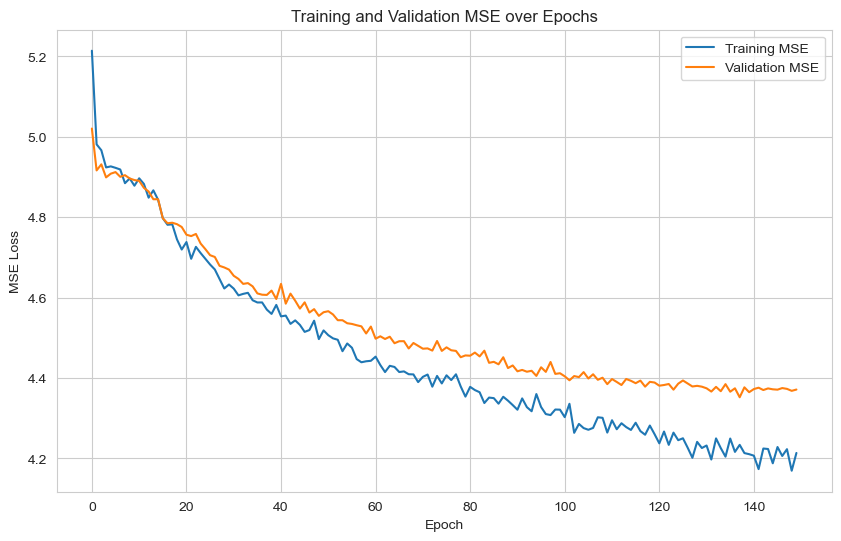

Epoch [150/150], Train MSE: 4.2134, Val MSE: 4.3712


In [19]:
def MSE_curves(train_mse, val_mse):
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(train_mse, label='Training MSE')
    plt.plot(val_mse, label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation MSE over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Prepare data
X = torch.tensor(probe_data, dtype=torch.float32) 
y = torch.tensor(latent_features, dtype=torch.float32)

dataset = TensorDataset(X, y)

# Split data
split = 0.8
train_size = int(split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize MLP
output_dim = 26 
model = DNN(probe_size=7, latent_size=output_dim)

# Loss and optimizer
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) 

num_epochs = 150
train_mses = []
val_mses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_mse = 0.0
    
    for batch_X, batch_y in train_loader:
        predictions = model(batch_X)
        mse_loss = criterion(predictions, batch_y)
        
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()
        
        epoch_mse += mse_loss.item()
    
    train_mses.append(epoch_mse / len(train_loader))

    # Validation
    model.eval()
    val_epoch_mse = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            mse_loss = criterion(predictions, batch_y)
            
            val_epoch_mse += mse_loss.item()
    
    val_mses.append(val_epoch_mse / len(val_loader))
    
    # Plot progress
    if (epoch + 1) % 5 == 0:
        MSE_curves(train_mses, val_mses)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train MSE: {train_mses[-1]:.4f}, Val MSE: {val_mses[-1]:.4f}')

Predicted latent shape: torch.Size([1, 26])


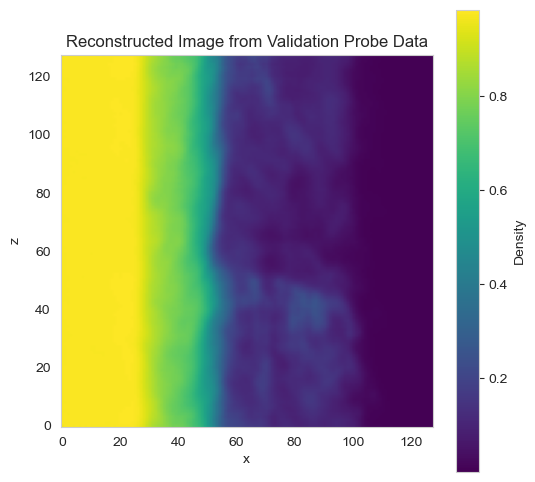

In [20]:
# Get validation sample
batch_X, batch_y = next(iter(val_loader))
idx = 0
probe_sample = batch_X[idx]

# Prepare input
input_tensor = probe_sample.unsqueeze(0)

# Predict latent representation with MLP
model.eval()
with torch.no_grad():
    latent_pred = model(input_tensor)

print(f"Predicted latent shape: {latent_pred.shape}")

# Decode with VAE
vae.eval()
with torch.no_grad():
    decoded_img = vae.conv_decoder(latent_pred)

# Plot reconstruction
decoded_img_np = decoded_img.squeeze().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(decoded_img_np.T, origin='lower', cmap='viridis') 
plt.colorbar(label='Density')
plt.title('Reconstructed Image from Validation Probe Data')
plt.xlabel('x')
plt.ylabel('z')
plt.grid(False)
plt.savefig("MLP_VAE_reconstruction.pdf")
plt.show()